# **LMPC for Autonomous Racing**

These notes were developed by Ugo Rosolia, Charlott Vallon and Francesco Borrelli at UC Berkeley, and Luigi Glielmo at Università di Napoli Federico II. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

You may not reproduce, distribute or display (post/upload) lecture notes or recordings or course materials in any way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

# AI Disclaimer

ChatGPT was used to accelerate the documentation of this code by suggesting docstring content for functions, classes, etc. Copilot in VSCode was used to help debug syntax errors that arose from the increased track complexity and modifications.

# Libraries
Several standard libraries are imported used throughout the code. These are first imported.

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import linalg as la
from numpy import hstack, inf, ones
from cvxopt import spmatrix, matrix, solvers
from cvxopt.solvers import qp
from cvxopt import spmatrix, matrix, solvers
from scipy import linalg
from scipy import sparse
from scipy.sparse import vstack
import datetime
from osqp import OSQP
from dataclasses import dataclass, field
import csv
import pandas as pd
import os
import glob

# Utility Functions

We move several utility functions from below the map class to a separate cell in this Jupyter notebook.

In [17]:
def computeAngle(point1, origin, point2):
    """
    Compute the signed angle (in radians) between two vectors defined by
    (origin -> point1) and (origin -> point2).

    The angle is positive for counterclockwise rotation from the first vector
    to the second, and negative for clockwise rotation. The result lies in
    the range [-pi, pi].

    Parameters
    ----------
    point1 : array-like of shape (2,)
        Coordinates of the first point.
    origin : array-like of shape (2,)
        Coordinates of the origin point.
    point2 : array-like of shape (2,)
        Coordinates of the second point.

    Returns
    -------
    angle : float
        Signed angle between the two vectors in radians.
    """
    v1 = np.array(point1) - np.array(origin)
    v2 = np.array(point2) - np.array(origin)

    dot = v1[0] * v2[0] + v1[1] * v2[1]
    det = v1[0] * v2[1] - v1[1] * v2[0]
    angle = np.arctan2(det, dot)
    return angle


def wrap(angle):
    """
    Wrap an angle to the interval [-pi, pi].

    If the input angle is outside the range [-pi, pi], it is shifted by
    adding or subtracting 2*pi to bring it back into the interval.

    Parameters
    ----------
    angle : float
        Angle in radians.

    Returns
    -------
    w_angle : float
        Wrapped angle in the range [-pi, pi].
    """
    if angle < -np.pi:
        w_angle = 2 * np.pi + angle
    elif angle > np.pi:
        w_angle = angle - 2 * np.pi
    else:
        w_angle = angle
    return w_angle


def sign(a):
    """
    Return the sign of a scalar value.

    Parameters
    ----------
    a : float or int
        Input value.

    Returns
    -------
    res : int
        1 if the input is greater than or equal to zero, -1 if it is negative.
    """
    if a >= 0:
        res = 1
    else:
        res = -1
    return res

# Map

We will use a curvilinear parameterization of different race track shapes.  Given a specified track shape parameter set, we will be able to coordinate between the curvilinear reference frame to the inertial reference frame (X,Y), and vice versa.

Several maps were previously hard-coded, these are replaced with a custom representation of the Yoshi Circuit in the popular game Mario Kart. This track was made by manually by adding segments, plotting the current track after each segment, and comparing the plot to an overlayed image of the inspiration.

In [18]:
class Map():
    """
    Track map representation based on piecewise straight and circular segments.

    The map defines a closed racing track using a sequence of segments, each characterized by a length and a signed curvature. From this representation,
    the class provides coordinate transformations between:

    - Curvilinear reference frame (s, ey)
    - Inertial/global frame (X, Y)

    It also allows querying geometric properties such as curvature and tangent angle along the track.

    Attributes
    ----------
    halfWidth : float
        Half width of the track (meters).
    slack : float
        Extra tolerance added to halfWidth when checking if a point is on track.
    PointAndTangent : ndarray, shape (N, 6)
        Track geometry table where each row contains:
        [x, y, psi, cumulative_s, segment_length, curvature]
    TrackLength : float
        Total length of the track (meters).
    """
    def __init__(self):
        """
        Initialize the track map.

        The track geometry is defined by a sequence of straight and curved
        segments specified in the `spec` array. Each segment is described by:

        - Segment length
        - Radius of curvature (0 for straight segments)

        From this specification, the method computes:
        - Global coordinates of segment endpoints
        - Tangent angle at each segment endpoint
        - Signed curvature for each segment

        The resulting track is closed by connecting the last point back
        to the origin.
        """
        self.halfWidth = 0.5
        self.slack = 0.35
        spec = np.array([
            [ 80 * 0.03,  +80 * 0.03 * ((12) / ( 8 * np.pi))],
            [ 20 * 0.03,   0],
            [ 20 * 0.03,   0],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 5 * np.pi))],
            [ 80 * 0.03,   0],
            [ 60 * 0.03,   0],
            [ 80 * 0.03,  +80 * 0.03 * ((12) / (10 * np.pi))],
            [ 40 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 2 * np.pi))],
            [ 60 * 0.03,   0],
            [ 80 * 0.03,  -80 * 0.03 * ((12) / (10 * np.pi))],
            [ 20 * 0.03,   0],
            [120 * 0.03, +120 * 0.03 * ((12) / ( 9 * np.pi))],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 6 * np.pi))],
            [120 * 0.03, +120 * 0.03 * ((12) / ( 9 * np.pi))],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 6 * np.pi))],
            [160 * 0.03, +160 * 0.03 * ((12) / (11 * np.pi))],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 6 * np.pi))],
            [ 40 * 0.03,   0],
            [200 * 0.03, +200 * 0.03 * ((12) / (12 * np.pi))],
            [ 40 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 7 * np.pi))],
            [ 80 * 0.03,   0],
            [ 40 * 0.03,  -40 * 0.03 * ((12) / ( 3 * np.pi))],
            [ 20 * 0.03,   0],
            [ 80 * 0.03,  +80 * 0.03 * ((12) / (12 * np.pi))],
            [ 40 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 5 * np.pi))],
            [ 20 * 0.03,   0],
            [ 60 * 0.03,  -60 * 0.03 * ((12) / ( 6 * np.pi))],
            [ 20 * 0.03,   0],
            [160 * 0.03, +160 * 0.03 * ((12) / ( 9 * np.pi))],
            [140 * 0.03,   0],
        ])

        # Now given the above segments we compute the (x, y) points of the track and the angle of the tangent vector (psi) at
        # these points. For each segment we compute the (x, y, psi) coordinate at the last point of the segment. Furthermore,
        # we compute also the cumulative s at the starting point of the segment at signed curvature
        # PointAndTangent = [x, y, psi, cumulative s, segment length, signed curvature]
        PointAndTangent = np.zeros((spec.shape[0] + 1, 6))
        for i in range(0, spec.shape[0]):
            if spec[i, 1] == 0.0:              # If the current segment is a straight line
                l = spec[i, 0]                 # Length of the segments
                if i == 0:
                    ang = 0                          # Angle of the tangent vector at the starting point of the segment
                    x = 0 + l * np.cos(ang)          # x coordinate of the last point of the segment
                    y = 0 + l * np.sin(ang)          # y coordinate of the last point of the segment
                else:
                    ang = PointAndTangent[i - 1, 2]                 # Angle of the tangent vector at the starting point of the segment
                    x = PointAndTangent[i-1, 0] + l * np.cos(ang)  # x coordinate of the last point of the segment
                    y = PointAndTangent[i-1, 1] + l * np.sin(ang)  # y coordinate of the last point of the segment
                psi = ang  # Angle of the tangent vector at the last point of the segment

                if i == 0:
                    NewLine = np.array([x, y, psi, PointAndTangent[i, 3], l, 0])
                else:
                    NewLine = np.array([x, y, psi, PointAndTangent[i-1, 3] + PointAndTangent[i-1, 4], l, 0])

                PointAndTangent[i, :] = NewLine  # Write the new info
            else:
                l = spec[i, 0]                 # Length of the segment
                r = spec[i, 1]                 # Radius of curvature

                if r >= 0:
                    direction = 1
                else:
                    direction = -1

                if i == 0:
                    ang = 0                                                      # Angle of the tangent vector at the
                                                                                 # starting point of the segment
                    CenterX = 0 \
                              + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
                    CenterY = 0 \
                              + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle
                else:
                    ang = PointAndTangent[i - 1, 2]                              # Angle of the tangent vector at the
                                                                                 # starting point of the segment
                    CenterX = PointAndTangent[i-1, 0] \
                              + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
                    CenterY = PointAndTangent[i-1, 1] \
                              + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle

                spanAng = l / np.abs(r)  # Angle spanned by the circle
                psi = wrap(ang + spanAng * np.sign(r))  # Angle of the tangent vector at the last point of the segment

                angleNormal = wrap((direction * np.pi / 2 + ang))
                angle = -(np.pi - np.abs(angleNormal)) * (sign(angleNormal))
                x = CenterX + np.abs(r) * np.cos(
                    angle + direction * spanAng)  # x coordinate of the last point of the segment
                y = CenterY + np.abs(r) * np.sin(
                    angle + direction * spanAng)  # y coordinate of the last point of the segment

                if i == 0:
                    NewLine = np.array([x, y, psi, PointAndTangent[i, 3], l, 1 / r])
                else:
                    NewLine = np.array([x, y, psi, PointAndTangent[i-1, 3] + PointAndTangent[i-1, 4], l, 1 / r])

                PointAndTangent[i, :] = NewLine  # Write the new info

        xs = PointAndTangent[-2, 0]
        ys = PointAndTangent[-2, 1]
        xf = 0
        yf = 0
        psif = 0
        l = np.sqrt((xf - xs) ** 2 + (yf - ys) ** 2)

        NewLine = np.array([xf, yf, psif, PointAndTangent[-2, 3] + PointAndTangent[-2, 4], l, 0])
        PointAndTangent[-1, :] = NewLine

        self.PointAndTangent = PointAndTangent
        self.TrackLength = PointAndTangent[-1, 3] + PointAndTangent[-1, 4]


    def getGlobalPosition(self, s, ey):
        """
        Convert curvilinear coordinates (s, ey) to global coordinates (X, Y).

        The curvilinear reference frame is defined as:
        - s  : distance along the track centerline
        - ey : lateral displacement from the centerline (positive to the left)

        Parameters
        ----------
        s : float
            Curvilinear distance along the track (meters). Automatically wrapped to the interval [0, TrackLength).
        ey : float
            Lateral offset from the track centerline (meters).

        Returns
        -------
        x : float
            Global X coordinate (meters).
        y : float
            Global Y coordinate (meters).
        """

        # Wrap s into [0, TrackLength)
        s = float(s) % self.TrackLength

        # Compute the segment in which system is evolving
        PointAndTangent = self.PointAndTangent

        # Find segment index robustly (handle boundary cases and multiple True values)
        index = np.all([[s >= PointAndTangent[:, 3]], [s < PointAndTangent[:, 3] + PointAndTangent[:, 4]]], axis=0)
        inds = np.where(np.squeeze(index))[0]
        if inds.size == 0:
            # If s falls exactly on the final boundary (or due to numerical issues), pick the last segment
            i = PointAndTangent.shape[0] - 1
        else:
            i = int(inds[0])

        if PointAndTangent[i, 5] == 0.0:  # If segment is a straight line
            # Extract the first final and initial point of the segment
            xf = PointAndTangent[i, 0]
            yf = PointAndTangent[i, 1]
            xs = PointAndTangent[i - 1, 0]
            ys = PointAndTangent[i - 1, 1]
            psi = PointAndTangent[i, 2]

            # Compute the segment length
            deltaL = PointAndTangent[i, 4]
            reltaL = s - PointAndTangent[i, 3]

            # Do the linear combination
            x = (1 - reltaL / deltaL) * xs + reltaL / deltaL * xf + ey * np.cos(psi + np.pi / 2)
            y = (1 - reltaL / deltaL) * ys + reltaL / deltaL * yf + ey * np.sin(psi + np.pi / 2)
        else:
            r = 1 / PointAndTangent[i, 5]  # Extract curvature
            ang = PointAndTangent[i - 1, 2]  # Extract angle of the tangent at the initial point (i-1)
            # Compute the center of the arc
            if r >= 0:
                direction = 1
            else:
                direction = -1

            CenterX = PointAndTangent[i - 1, 0] \
                      + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
            CenterY = PointAndTangent[i - 1, 1] \
                      + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle

            spanAng = (s - PointAndTangent[i, 3]) / (np.pi * np.abs(r)) * np.pi

            angleNormal = wrap((direction * np.pi / 2 + ang))
            angle = -(np.pi - np.abs(angleNormal)) * (sign(angleNormal))

            x = CenterX + (np.abs(r) - direction * ey) * np.cos(
                angle + direction * spanAng)  # x coordinate of the last point of the segment
            y = CenterY + (np.abs(r) - direction * ey) * np.sin(
                angle + direction * spanAng)  # y coordinate of the last point of the segment

        return x, y

    def getLocalPosition(self, x, y, psi):
        """
        Convert global coordinates (X, Y, psi) to curvilinear coordinates (s, ey).

        The method determines which track segment the point lies on and computes
        the corresponding curvilinear coordinates. If the point does not lie
        within the track boundaries (including slack), an error is reported.

        Parameters
        ----------
        x : float
            Global X coordinate (meters).
        y : float
            Global Y coordinate (meters).
        psi : float
            Heading angle in the global frame (radians).

        Returns
        -------
        s : float
            Curvilinear distance along the track (meters).
        ey : float
            Lateral displacement from the centerline (meters).
        epsi : float
            Heading error relative to the track tangent (radians).
        CompletedFlag : int
            1 if the conversion was successful (point on track),
            0 otherwise.
        """

        PointAndTangent = self.PointAndTangent
        CompletedFlag = 0

        for i in range(0, PointAndTangent.shape[0]):
            if CompletedFlag == 1:
                break

            if PointAndTangent[i, 5] == 0.0:  # If segment is a straight line
                # Extract the first final and initial point of the segment
                xf = PointAndTangent[i, 0]
                yf = PointAndTangent[i, 1]
                xs = PointAndTangent[i - 1, 0]
                ys = PointAndTangent[i - 1, 1]

                psi_unwrap = np.unwrap([PointAndTangent[i - 1, 2], psi])[1]
                epsi = psi_unwrap - PointAndTangent[i - 1, 2]
                # Check if on the segment using angles
                if (la.norm(np.array([xs, ys]) - np.array([x, y]))) == 0:
                    s  = PointAndTangent[i, 3]
                    ey = 0
                    CompletedFlag = 1

                elif (la.norm(np.array([xf, yf]) - np.array([x, y]))) == 0:
                    s = PointAndTangent[i, 3] + PointAndTangent[i, 4]
                    ey = 0
                    CompletedFlag = 1
                else:
                    if np.abs(computeAngle( [x,y] , [xs, ys], [xf, yf])) <= np.pi/2 and np.abs(computeAngle( [x,y] , [xf, yf], [xs, ys])) <= np.pi/2:
                        v1 = np.array([x,y]) - np.array([xs, ys])
                        angle = computeAngle( [xf,yf] , [xs, ys], [x, y])
                        s_local = la.norm(v1) * np.cos(angle)
                        s       = s_local + PointAndTangent[i, 3]
                        ey      = la.norm(v1) * np.sin(angle)

                        if np.abs(ey)<= self.halfWidth + self.slack:
                            CompletedFlag = 1

            else:
                xf = PointAndTangent[i, 0]
                yf = PointAndTangent[i, 1]
                xs = PointAndTangent[i - 1, 0]
                ys = PointAndTangent[i - 1, 1]

                r = 1 / PointAndTangent[i, 5]  # Extract curvature
                if r >= 0:
                    direction = 1
                else:
                    direction = -1

                ang = PointAndTangent[i - 1, 2]  # Extract angle of the tangent at the initial point (i-1)

                # Compute the center of the arc
                CenterX = xs + np.abs(r) * np.cos(ang + direction * np.pi / 2)  # x coordinate center of circle
                CenterY = ys + np.abs(r) * np.sin(ang + direction * np.pi / 2)  # y coordinate center of circle

                # Check if on the segment using angles
                if (la.norm(np.array([xs, ys]) - np.array([x, y]))) == 0:
                    ey = 0
                    psi_unwrap = np.unwrap([ang, psi])[1]
                    epsi = psi_unwrap - ang
                    s = PointAndTangent[i, 3]
                    CompletedFlag = 1
                elif (la.norm(np.array([xf, yf]) - np.array([x, y]))) == 0:
                    s = PointAndTangent[i, 3] + PointAndTangent[i, 4]
                    ey = 0
                    psi_unwrap = np.unwrap([PointAndTangent[i, 2], psi])[1]
                    epsi = psi_unwrap - PointAndTangent[i, 2]
                    CompletedFlag = 1
                else:
                    arc1 = PointAndTangent[i, 4] * PointAndTangent[i, 5]
                    arc2 = computeAngle([xs, ys], [CenterX, CenterY], [x, y])
                    if np.sign(arc1) == np.sign(arc2) and np.abs(arc1) >= np.abs(arc2):
                        v = np.array([x, y]) - np.array([CenterX, CenterY])
                        s_local = np.abs(arc2)*np.abs(r)
                        s    = s_local + PointAndTangent[i, 3]
                        ey   = -np.sign(direction) * (la.norm(v) - np.abs(r))
                        psi_unwrap = np.unwrap([ang + arc2, psi])[1]
                        epsi = psi_unwrap - (ang + arc2)

                        if np.abs(ey) <= self.halfWidth + self.slack:
                            CompletedFlag = 1

        if CompletedFlag == 0:
            s    = 10000
            ey   = 10000
            epsi = 10000

            print("Error!! POINT OUT OF THE TRACK!!!! <==================")

        return s, ey, epsi, CompletedFlag


    def curvature(self, s):
        """
        Evaluate track curvature at a given curvilinear position.

        Curvature is piecewise constant and defined per segment.

        Parameters
        ----------
        s : float
            Curvilinear distance along the track (meters). Automatically wrapped to the interval [0, TrackLength).

        Returns
        -------
        curvature : float
            Signed curvature at position s (1/m).
            Zero indicates a straight segment.
        """
        TrackLength = self.PointAndTangent[-1,3]+self.PointAndTangent[-1,4]

        # Wrap s into [0, TrackLength)
        s = float(s) % TrackLength

        # Given s \in [0, TrackLength] compute the curvature
        # Compute the segment in which system is evolving
        index = np.all([[s >= self.PointAndTangent[:, 3]], [s < self.PointAndTangent[:, 3] + self.PointAndTangent[:, 4]]], axis=0)
        i = int(np.where(np.squeeze(index))[0])
        
        curvature = self.PointAndTangent[i, 5]

        return curvature


    def getAngle(self, s, epsi):
        """
        Compute the global heading angle at a given curvilinear position.

        The heading angle is obtained by summing:
        - The track tangent angle at position s
        - The heading error epsi

        Parameters
        ----------
        s : float
            Curvilinear distance along the track (meters).
        epsi : float
            Heading error relative to the track tangent (radians).

        Returns
        -------
        angle_at_s : float
            Global heading angle (radians).
        """
        TrackLength = self.PointAndTangent[-1,3]+self.PointAndTangent[-1,4]

        # Wrap s into [0, TrackLength)
        s = float(s) % TrackLength

        # Given s \in [0, TrackLength] compute the curvature
        # Compute the segment in which system is evolving
        index = np.all([[s >= self.PointAndTangent[:, 3]], [s < self.PointAndTangent[:, 3] + self.PointAndTangent[:, 4]]], axis=0)
        i = int(np.where(np.squeeze(index))[0])
        if i > 0:
            ang = self.PointAndTangent[i - 1, 2]
        else:
            ang = 0

        if self.PointAndTangent[i, 5] == 0:
            r= 0
        else:
            r = 1 / self.PointAndTangent[i, 5]  # Radius of curvature

        if r == 0:
            # On a straight part of the circuit
            angle_at_s = ang + epsi
        else:
            # On a curve
            cumulative_s = self.PointAndTangent[i, 3]
            relative_s = s - cumulative_s
            spanAng = relative_s / np.abs(r)  # Angle spanned by the circle
            psi = wrap(ang + spanAng * np.sign(r))  # Angle of the tangent vector at the last point of the segment
            angle_at_s = psi + epsi

        return angle_at_s


# Wind Model

Here we implement a simple stochastic wind model that models an environmental disturbance. In the contex of mariokart, some tracks include green pipes that blow the player's care towards either edge of the track.

In [21]:
# Wind model: Gaussian speed, westward mean direction
from dataclasses import dataclass

np.random.seed(42) # for reproducibility

@dataclass
class WindParams:
    """
    Parameters defining the stochastic wind model.

    Wind speed and direction are modeled as independent Gaussian random variables with optional clipping on the speed to enforce physical limits.

    Attributes
    ----------
    mean_speed : float
        Mean wind speed (m/s).
    std_speed : float
        Standard deviation of wind speed (m/s).
    mean_dir : float
        Mean wind direction in radians (global frame).
        Default pi corresponds to wind blowing westward.
    std_dir : float
        Standard deviation of wind direction (radians).
    min_speed : float
        Minimum allowable wind speed (m/s).
    max_speed : float
        Maximum allowable wind speed (m/s).
    """
    mean_speed: float = 0.5   # m/s
    std_speed: float = 0.5    # m/s (variance=std^2)
    mean_dir: float = np.pi   # radians, west (assumed ENU reference frame)
    std_dir: float = 0.2      # radians spread around west
    min_speed: float = 0.0    # m/s
    max_speed: float = 1.5    # m/s


class WindModel:
    """
    Stochastic wind model with Gaussian-distributed speed and direction.

    This class provides methods to:
    - Sample wind magnitude and direction in the global frame
    - Convert wind vectors from the global frame to the vehicle body frame
    """
    def __init__(self, params: WindParams = WindParams()):
        """
        Initialize the wind model.

        Parameters
        ----------
        params : WindParams, optional
            Wind model parameters. If not provided, default parameters are used.
        """
        self.params = params


    def sample(self):
        """
        Sample a wind measurement in the global (inertial) frame.

        Wind speed and direction are sampled independently from Gaussian distributions. The wind speed is clipped to lie within specified bounds.

        Returns
        -------
        v : float
            Wind speed magnitude (m/s).
        theta : float
            Wind direction angle in radians (global frame).
        wind_global : ndarray, shape (2,)
            Wind velocity vector in the global frame [Wx, Wy].
        """
        v = np.random.normal(self.params.mean_speed, self.params.std_speed)
        v = np.clip(v, self.params.min_speed, self.params.max_speed) # ensure wind speed within realistic bounds
        theta = np.random.normal(self.params.mean_dir, self.params.std_dir) # wind variation in direction
        w_x = v * np.cos(theta)
        w_y = v * np.sin(theta)
        return v, theta, np.array([w_x, w_y])


    def to_body(self, wind_global, psi):
        """
        Rotate a global wind vector into the vehicle body frame.

        The body frame is defined as:
        - x-axis: vehicle longitudinal axis (forward)
        - y-axis: vehicle lateral axis (to the right)

        Parameters
        ----------
        wind_global : ndarray, shape (2,)
            Wind vector in the global frame [Wx, Wy].
        psi : float
            Vehicle yaw angle in the global frame (radians).

        Returns
        -------
        wind_body : ndarray, shape (2,)
            Wind vector expressed in the vehicle body frame:
            - wind_body[0]: longitudinal component (positive = tailwind)
            - wind_body[1]: lateral component (positive = wind pushing right)
        """
        c, s = np.cos(psi), np.sin(psi)
        rot = np.array([[c, s], [-s, c]]) # rotation matrix from global to body frame
        return rot @ wind_global # rotate into body frame,
                                 # wind_body[0]: wind along vehicle longitudinal axis, (+) tailwind
                                 # wind_body[1]: wind along vehicle lateral axis, (+) wind pushes car to the right

# Simulator

The simulator defines the "real" system; here, we use a dynamic bicycle model defined in the curvilinear abscessa frame. Note that our LMPC controller later will estimate a linearized version of this model using data, so $f$ and $f_{test}$ will be different!

In [22]:
class SIMULATOR(object):
	"""
    Vehicle simulation environment with support for nonlinear dynamics,
    track geometry, and stochastic wind disturbances.

    The simulator propagates vehicle states forward in time using a
    discrete-time integration of a dynamic bicycle model. States are
    maintained both in:
    - Curvilinear (track-relative) coordinates
    - Global (inertial) coordinates

    Supported features include:
    - Nonlinear tire dynamics (Pacejka-like)
    - Aerodynamic drag and side force due to wind
    - Track curvature effects
    - Process noise on velocities

    Parameters
    ----------
    system : str
        Identifier of the system dynamics model to simulate
        (e.g. "dyn_bicycle_model").
    dt : float, optional
        Simulation time step (seconds).
    map : Map
        Track map object providing curvature and coordinate transforms.
    wind_model : WindModel or None, optional
        Wind model used to generate aerodynamic disturbances.
        If None, no wind is applied.
    """
	def __init__(self, system, dt = 0.1,  map = [], wind_model = None):
		"""
        Initialize the simulator.

        Parameters
        ----------
        system : str
            Name of the vehicle dynamics model to use.
        dt : float, optional
            Simulation time step (seconds).
        map : Map
            Track map instance.
        wind_model : WindModel or None, optional
            Wind model used to sample wind disturbances.
        """
		self.system = system
		self.dt = dt
		self.map = map
		self.wind_model = wind_model


	def sim(self, x, u):
		"""
        Propagate the system dynamics for one simulation step.

        Parameters
        ----------
        x : list
            Current state, structured as:
            [curvilinear_state, global_state]
        u : array-like
            Control input vector:
            - u[0]: steering angle (rad)
            - u[1]: longitudinal acceleration (m/s^2)

        Returns
        -------
        x_next : list
            Next state after dt seconds:
            [next_curvilinear_state, next_global_state]
        """
		if self.system == "dyn_bicycle_model":
			x, x_glob = self.dyn_bicycle_model(x, u)
			x_next = [x, x_glob]
		return x_next


	def computeRoadEdges(self, s_start, s_end, circleRadius, roadHalfWidth, signEdge = 1, disc = 1):
		"""
        Compute road edge coordinates for a circular track segment.

        Parameters
        ----------
        s_start : float
            Starting curvilinear abscissa (meters).
        s_end : float
            Ending curvilinear abscissa (meters).
        circleRadius : float
            Radius of the track centerline (meters).
        roadHalfWidth : float
            Half width of the road (meters).
        signEdge : int, optional
            +1 for outer edge, -1 for inner edge.
        disc : float, optional
            Discretization step along s (meters).

        Returns
        -------
        edges : ndarray, shape (N, 2)
            XY coordinates of the road edge.
        """
		edges = []
		for k in np.arange(s_start, s_end+disc, disc):#in range(s_start*disc, s_end*disc):
			angle  = k/circleRadius
			radius = circleRadius  + signEdge * roadHalfWidth
			edges.append([radius*np.sin(angle), circleRadius-radius*np.cos(angle)])
		return np.array(edges)


	def from_curvilinear_to_xy(self, xcl_feasible):
		"""
        Convert a trajectory from curvilinear to global coordinates.

        Parameters
        ----------
        xcl_feasible : ndarray, shape (N, 2)
            Curvilinear trajectory where each row contains:
            [s, ey]

        Returns
        -------
        feasibleTraj : list of list
            Global XY coordinates of the trajectory.
        """
		feasibleTraj = []
		for k in range(0, np.shape(np.array(xcl_feasible))[0]):
			angle  = np.array(xcl_feasible)[k, 0]/self.radius
			radius_curr = self.radius  - np.array(xcl_feasible)[k, 1]
			feasibleTraj.append([radius_curr*np.sin(angle), self.radius-radius_curr*np.cos(angle)])
		return feasibleTraj

	def dyn_bicycle_model(self, x_states_list, u):
		"""
        Propagate the nonlinear dynamic bicycle model.

        The dynamics include:
        - Nonlinear tire forces (Pacejka-like model)
        - Aerodynamic drag and side forces
        - Wind disturbances (if enabled)
        - Track curvature effects
        - Additive process noise

        The model is integrated using a fixed-step Euler scheme
        with an internal discretization smaller than the simulator
        time step.

        Parameters
        ----------
        x_states_list : list
            Current state:
            - x_states_list[0]: curvilinear state vector
              [vx, vy, wz, epsi, s, ey]
            - x_states_list[1]: global state vector
              [vx, vy, wz, psi, X, Y]
        u : array-like
            Control input:
            - u[0]: steering angle (rad)
            - u[1]: longitudinal acceleration (m/s^2)

        Returns
        -------
        cur_x_next : list
            Next curvilinear state after dt seconds.
        x_next : list
            Next global state after dt seconds.
        """
		# This method computes the system evolution. Note that the discretization is deltaT and therefore is needed that
		# dt <= deltaT and ( dt / deltaT) = integer value
		x = np.array(x_states_list[0])
		x_glob = np.array(x_states_list[1])

		# Vehicle Parameters
		m  = 1.98
		lf = 0.125
		lr = 0.125
		Iz = 0.024
		Df = 0.8 * m * 9.81 / 2.0
		Cf = 1.25
		Bf = 1.0
		Dr = 0.8 * m * 9.81 / 2.0
		Cr = 1.25
		Br = 1.0

		# Aerodynamic Parameters
		rho = 1.2  # Air density kg/m^3
		CdA = 0.01  # Drag area m^2, drag coefficient*front area, higher CdA means more drag
		CyA = 0.008  # Side area m^2, side force coefficient*side area, higher CyA means more side force, for cross wind
		x_cp = 0.0  # Center of pressure offset from CG (m)

		# Discretization Parameters
		deltaT = 0.001
		x_next	 = np.zeros(x.shape[0])
		cur_x_next = np.zeros(x.shape[0])
		# Extract the value of the states
		delta = u[0]
		a	 = u[1]
		psi = x_glob[3]
		X = x_glob[4]
		Y = x_glob[5]
		vx	= x[0]
		vy	= x[1]
		wz	= x[2]
		epsi  = x[3]
		s	 = x[4]
		ey	= x[5]

		# Sample wind (once per simulation step)
		if self.wind_model is not None:
			v_wind, theta_wind, wind_global = self.wind_model.sample()
		else:
			wind_global = np.array([0.0, 0.0])

		# Initialize counter
		i = 0
		while( (i+1) * deltaT <= self.dt):
			# Compute wind in body frame
			if self.wind_model is not None:
				wind_body = self.wind_model.to_body(wind_global, psi)
				v_rel_x = vx - wind_body[0]
				v_rel_y = vy - wind_body[1]
				# Aerodynamic forces
				F_ax = -0.5 * rho * CdA * v_rel_x * np.abs(v_rel_x)
				F_ay = 0.5 * rho * CyA * v_rel_y * np.abs(v_rel_y)
				M_wz = F_ay * x_cp
			else:
				F_ax = 0.0
				F_ay = 0.0
				M_wz = 0.0

			# print(F_ax, F_ay, M_wz)

			# Compute tire split angle
			alpha_f = delta - np.arctan2( vy + lf * wz, vx )
			alpha_r = - np.arctan2( vy - lf * wz , vx)
			# Compute lateral force at front and rear tire
			Fyf = Df * np.sin( Cf * np.arctan(Bf * alpha_f ) )
			Fyr = Dr * np.sin( Cr * np.arctan(Br * alpha_r ) )
			# Propagate the dynamics of deltaT
			x_next[0] = vx  + deltaT * (a - 1 / m * Fyf * np.sin(delta) + wz*vy + F_ax / m)
			x_next[1] = vy  + deltaT * (1 / m * (Fyf * np.cos(delta) + Fyr) - wz * vx + F_ay / m)
			x_next[2] = wz  + deltaT * (1 / Iz *(lf * Fyf * np.cos(delta) - lr * Fyr) + M_wz / Iz)
			x_next[3] = psi + deltaT * (wz)
			x_next[4] =   X + deltaT * ((vx * np.cos(psi) - vy * np.sin(psi)))
			x_next[5] =   Y + deltaT * (vx * np.sin(psi)  + vy * np.cos(psi))

			cur = self.map.curvature(s)
			cur_x_next[0] = vx   + deltaT * (a - 1 / m * Fyf * np.sin(delta) + wz*vy + F_ax / m)
			cur_x_next[1] = vy   + deltaT * (1 / m * (Fyf * np.cos(delta) + Fyr) - wz * vx + F_ay / m)
			cur_x_next[2] = wz   + deltaT * (1 / Iz *(lf * Fyf * np.cos(delta) - lr * Fyr) + M_wz / Iz)
			cur_x_next[3] = epsi + deltaT * ( wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur )
			cur_x_next[4] = s	+ deltaT * ( (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) )
			cur_x_next[5] = ey   + deltaT * (vx * np.sin(epsi) + vy * np.cos(epsi))

			# Update the value of the states
			psi  = x_next[3]
			X	= x_next[4]
			Y	= x_next[5]
			vx   = cur_x_next[0]
			vy   = cur_x_next[1]
			wz   = cur_x_next[2]
			epsi = cur_x_next[3]
			s	= cur_x_next[4]
			ey   = cur_x_next[5]

			# Increment counter
			i = i+1

		# Noises
		noise_vx = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_vy = np.max([-0.05, np.min([np.random.randn() * 0.01, 0.05])])
		noise_wz = np.max([-0.05, np.min([np.random.randn() * 0.005, 0.05])])

		cur_x_next[0] = cur_x_next[0] + 0.01*noise_vx
		cur_x_next[1] = cur_x_next[1] + 0.01*noise_vy
		cur_x_next[2] = cur_x_next[2] + 0.01*noise_wz

		x_next[0] = x_next[0] + 0.01*noise_vx
		x_next[1] = x_next[1] + 0.01*noise_vy
		x_next[2] = x_next[2] + 0.01*noise_wz

		return cur_x_next.tolist(), x_next.tolist()

# First Lap
We will begin by finding a sub-optimal, but feasible, state and input trajectory with which to initialize our LMPC controller later. Here we use a PID controller that will track the centerline of the track.

In [23]:
class PID:
    """
    Simple PID-like controller for path following at constant speed.

    This controller computes steering and longitudinal acceleration control input based on the current curvilinear state of the vehicle. It is intended as a lightweight baseline controller for LMPC learning rather than a full optimal controller.

    Control objectives:
    - Minimize lateral deviation from the track centerline
    - Minimize heading error relative to the track tangent
    - Regulate longitudinal speed to a desired target velocity

    Attributes
    ----------
    vt : float
        Target longitudinal velocity (m/s).
    uPred : ndarray, shape (2, 1)
        Predicted control input:
        - uPred[0]: steering command (rad)
        - uPred[1]: longitudinal acceleration command (m/s^2)
    solverTime : datetime.timedelta
        Placeholder timing variable for solver execution time.
    linearizationTime : datetime.timedelta
        Placeholder timing variable for model linearization time.
    feasible : int
        Feasibility flag (1 = feasible solution).
    """

    def __init__(self, vt):
        """
        Initialize the PID controller.

        Parameters
        ----------
        vt : float
            Desired target longitudinal velocity (m/s).
        """
        self.vt = vt
        self.uPred = np.zeros([2,1])

        startTimer = datetime.datetime.now()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        self.linearizationTime = deltaTimer
        self.feasible = 1


    def solve(self, x0):
        """
        Compute the control action based on the current state.

        The controller applies proportional feedback on:
        - Lateral displacement (ey)
        - Heading error (epsi)
        - Velocity tracking error (vt - vx)

        Additive bounded Gaussian noise is included to model actuation
        uncertainty or to improve exploration.

        Parameters
        ----------
        x0 : array-like
            Current curvilinear state vector:
            [vx, vy, wz, epsi, s, ey]

        Returns
        -------
        uPred : ndarray, shape (2, 1)
            Control input:
            - uPred[0]: steering command (rad)
            - uPred[1]: longitudinal acceleration command (m/s^2)
        """
        vt = self.vt
        self.uPred[0, 0] = - 0.6 * x0[5] - 0.9 * x0[3] + np.max([-0.9, np.min([np.random.randn() * 0.25, 0.9])])
        self.uPred[1, 0] = 1.5 * (vt - x0[0]) + np.max([-0.2, np.min([np.random.randn() * 0.10, 0.2])])


In [24]:
# ======================================================================================================================
# ============================================= Initialize parameters  =================================================
# ======================================================================================================================
x0 = [0.5, 0, 0, 0, 0, 0]                 # Initial condition
dt = 0.1

map = Map()                               # Initialize map
vt = 0.8                                  # target velocity

wind_model = WindModel()                  # Initialize wind model

simulator = SIMULATOR("dyn_bicycle_model", map=map, dt=dt, wind_model=wind_model) # Init simulators

# ======================================================================================================================
# ======================================= PID path following ===========================================================
# ======================================================================================================================
print("Starting PID")
# Initialize pid and run sim
PIDController = PID(vt)
t_max = 3000

xcl_pid = [x0]
xcl_pid_glob = [x0]
ucl_pid = []

for time in range(t_max):
    # read measurement
    xt = xcl_pid[time]

    # Solve LMPC
    PIDController.solve(xt)

    # Apply input and store closed-loop data
    ut = PIDController.uPred[:,0]
    ucl_pid.append(ut.tolist())
    x_next = simulator.sim([xcl_pid[time], xcl_pid_glob[time]], ut) # Simulate both in global and local coordinates
    xcl_pid.append(x_next[0])
    xcl_pid_glob.append(x_next[1])

    # increment time counter
    time += 1

Starting PID


/tmp/ipykernel_30928/4152955430.py:386: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(np.squeeze(index))[0])


# Cost Model

Here, a custom cost model is implemented to encourage corner hugging in early iterations, before returning to time-optimal learning in later iterations.


In [28]:
class CostModel():
    """
    Cost model for lateral deviation relative to track geometry.

    This class defines a scalar stage cost that penalizes lateral deviation from the track centerline or edges, with a penalty that depends on:
    - Track curvature at the current position
    - Prediction horizon index (via a decay term)

    The cost has the general form:

        cost = 1 + decay(N) * error(ey, s)

    where straight segments receive a mild quadratic penalty around the centerline, and curved segments bias the penalty toward the outer edge of the track.
    """
    def __init__(self,map:Map,k1=0.0,k2=1.0):
        """
        Initialize the cost model.

        Parameters
        ----------
        map : Map
            Track map object used to evaluate curvature and track width.
        k1 : float, optional
            Scaling factor for the error cost contribution.
        k2 : float, optional
            Horizon decay shaping parameter. Larger values produce slower decay.
        """
        self.map = map
        self.k1 = k1
        self.k2 = k2
        self.w = self.map.halfWidth


    def error(self,ye,s):
        """
        Compute normalized lateral error cost term.

        On straight segments, the error penalizes deviation from the track centerline. On curved segments, the error is biased toward the outer edge of the curve.

        Parameters
        ----------
        ye : float
            Lateral deviation from the track centerline (meters).
        s : float
            Curvilinear abscissa along the track (meters).

        Returns
        -------
        error_cost : float
            Normalized squared lateral error.
        """
        s = s % self.map.TrackLength
        c = self.map.curvature(s)
        if np.abs(c) <= 0.01:
            return 0.01 * (ye / self.w)**2
        return ((ye - np.sign(c) * self.w) / self.w) ** 2
    

    def decay(self,N):
        """
        Compute horizon-dependent decay factor.

        The decay term reduces the influence of lateral error cost as the prediction horizon index increases.

        Parameters
        ----------
        N : int
            Prediction step index. Use N = -1 to disable the decay term.

        Returns
        -------
        decay_value : float
            Scalar decay factor applied to the error cost.
        """
        if (N == -1):
            return 0.0
        k2 = (1.0 - np.tanh(N / self.k2) ** 2)
        if (k2 < 0.1):
            return 0.0
        return self.k1 * k2


    def cost(self,ye,s,N):
        """
        Compute the total roll-out cost.

        Parameters
        ----------
        ye : float
            Lateral deviation from the track centerline (meters).
        s : float
            Curvilinear abscissa along the track (meters).
        N : int
            Prediction horizon index.

        Returns
        -------
        cost : float
            Scalar roll-out cost value.
        """
        d = self.decay(N)
        f = self.error(ye,s)
        cost = 1.0 + d * f
        return cost


In [29]:

k1 = 10
k2 = 1

filename = f'k1_{k1}_k2_{k2}.csv'
cost_model = CostModel(map=map,k1=k1,k2=k2)

# LMPC Code

In [30]:
@dataclass
class PythonMsg:
    def __setattr__(self,key,value):
        if not hasattr(self,key):
            raise TypeError ('Cannot add new field "%s" to frozen class %s' %(key,self))
        else:
            object.__setattr__(self,key,value)

@dataclass
class MPCParams(PythonMsg):
    n: int = field(default=None) # dimension state space
    d: int = field(default=None) # dimension input space
    N: int = field(default=None) # horizon length

    A: np.array = field(default=None) # prediction matrices. Single matrix for LTI and list for LTV
    B: np.array = field(default=None) # prediction matrices. Single matrix for LTI and list for LTV

    #Q: np.array = field(default=np.array((n, n))) # quadratic state cost
    Q: np.array = field(default=None) # quadratic state cost
    R: np.array = field(default=None) # quadratic input cost
    Qf: np.array = field(default=None) # quadratic state cost final
    dR: np.array = field(default=None) # Quadratic rate cost

    Qslack: float = field(default=None) # it has to be a vector. Qslack = [linearSlackCost, quadraticSlackCost]
    Fx: np.array = field(default=None) # State constraint Fx * x <= bx
    bx: np.array = field(default=None)
    Fu: np.array = field(default=None) # State constraint Fu * u <= bu
    bu: np.array = field(default=None)
    xRef: np.array = field(default=None)

    slacks: bool = field(default=True)
    timeVarying: bool = field(default=False)

    def __post_init__(self):
        if self.Qf is None: self.Qf = np.zeros((self.n, self.n))
        if self.dR is None: self.dR = np.zeros(self.d)
        if self.xRef is None: self.xRef = np.zeros(self.n)

# MPC
class MPC():
    """Model Predicitve Controller class
    Methods (needed by user):
        solve: given system's state xt compute control action at
    Arguments:
        mpcParameters: model paramters
    """
    def __init__(self,  mpcParameters, predictiveModel=[]):
        """Initialization
        Arguments:
            mpcParameters: struct containing MPC parameters
        """
        self.N      = mpcParameters.N
        self.Qslack = mpcParameters.Qslack
        self.Q      = mpcParameters.Q
        self.Qf     = mpcParameters.Qf
        self.R      = mpcParameters.R
        self.dR     = mpcParameters.dR
        self.n      = mpcParameters.n
        self.d      = mpcParameters.d
        self.A      = mpcParameters.A
        self.B      = mpcParameters.B
        self.Fx     = mpcParameters.Fx
        self.Fu     = mpcParameters.Fu
        self.bx     = mpcParameters.bx
        self.bu     = mpcParameters.bu
        self.xRef   = mpcParameters.xRef

        self.slacks          = mpcParameters.slacks
        self.timeVarying     = mpcParameters.timeVarying
        self.predictiveModel = predictiveModel

        if self.timeVarying == True:
            self.xLin = self.predictiveModel.xStored[-1][0:self.N+1,:]
            self.uLin = self.predictiveModel.uStored[-1][0:self.N,:]
            self.computeLTVdynamics()
        self.OldInput = np.zeros((1,2))
        # Build matrices for inequality constraints
        self.buildIneqConstr()
        self.buildCost()
        self.buildEqConstr()
        self.xPred = []
        # initialize time
        startTimer = datetime.datetime.now()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        self.linearizationTime = deltaTimer
        self.timeStep = 0

    def solve(self, x0):
        """Computes control action
        Arguments:
            x0: current state
        """
        # If LTV active --> identify system model
        if self.timeVarying == True:
            self.computeLTVdynamics()
            self.buildCost()
            self.buildEqConstr()
        self.addTerminalComponents(x0)
        # Solve QP
        startTimer = datetime.datetime.now()
        self.osqp_solve_qp(self.H_FTOCP, self.q_FTOCP, self.F_FTOCP, self.b_FTOCP, self.G_FTOCP, np.add(np.dot(self.E_FTOCP,x0),self.L_FTOCP))
        self.unpackSolution()
        endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
        self.solverTime = deltaTimer
        # If LTV active --> compute state-input linearization trajectory
        self.feasibleStateInput()
        if self.timeVarying == True:
            self.xLin = np.vstack((self.xPred[1:, :], self.zt))
            self.uLin = np.vstack((self.uPred[1:, :], self.zt_u))
        # update applied input
        self.OldInput = self.uPred[0,:]
        self.timeStep += 1

    def computeLTVdynamics(self):
        # Estimate system dynamics
        self.A = []; self.B = []; self.C =[]
        for i in range(0, self.N):
            Ai, Bi, Ci = self.predictiveModel.regressionAndLinearization(self.xLin[i], self.uLin[i])
            self.A.append(Ai); self.B.append(Bi); self.C.append(Ci)

    def addTerminalComponents(self, x0):
        self.H_FTOCP = sparse.csc_matrix(self.H)
        self.q_FTOCP = self.q
        self.F_FTOCP = sparse.csc_matrix(self.F)
        self.b_FTOCP = self.b
        self.G_FTOCP = sparse.csc_matrix(self.G)
        self.E_FTOCP = self.E
        self.L_FTOCP = self.L

    def feasibleStateInput(self):
        self.zt   = self.xPred[-1,:]
        self.zt_u = self.uPred[-1,:]

    def unpackSolution(self):
        # Extract predicted state and predicted input trajectories
        self.xPred = np.squeeze(np.transpose(np.reshape((self.Solution[np.arange(self.n*(self.N+1))]),(self.N+1,self.n)))).T
        self.uPred = np.squeeze(np.transpose(np.reshape((self.Solution[self.n*(self.N+1)+np.arange(self.d*self.N)]),(self.N, self.d)))).T

    def buildIneqConstr(self):
        # The inequality constraint is Fz<=b
        rep_a = [self.Fx] * (self.N)
        Mat = linalg.block_diag(*rep_a)
        NoTerminalConstr = np.zeros((np.shape(Mat)[0], self.n))  # The last state is unconstrained. There is a specific function add the terminal constraints (so that more complicated terminal constrains can be handled)
        Fxtot = np.hstack((Mat, NoTerminalConstr))
        bxtot = np.tile(np.squeeze(self.bx), self.N)
        # Let's start by computing the submatrix of F relates with the input
        rep_b = [self.Fu] * (self.N)
        Futot = linalg.block_diag(*rep_b)
        butot = np.tile(np.squeeze(self.bu), self.N)
        # Let's stack all together
        F_hard = linalg.block_diag(Fxtot, Futot)
        # Add slack if need
        if self.slacks == True:
            nc_x = self.Fx.shape[0] # add slack only for state constraints
            # Fist add add slack to existing constraints
            addSlack = np.zeros((F_hard.shape[0], nc_x*self.N))
            addSlack[0:nc_x*(self.N), 0:nc_x*(self.N)] = -np.eye(nc_x*(self.N))
            # Now constraint slacks >= 0
            I = - np.eye(nc_x*self.N); Zeros = np.zeros((nc_x*self.N, F_hard.shape[1]))
            Positivity = np.hstack((Zeros, I))
            # Let's stack all together
            self.F = np.vstack(( np.hstack((F_hard, addSlack)) , Positivity))
            self.b = np.hstack((bxtot, butot, np.zeros(nc_x*self.N)))
        else:
            self.F = F_hard
            self.b = np.hstack((bxtot, butot))

    def buildEqConstr(self):
        # Buil matrices for optimization (Convention from Chapter 15.2 Borrelli, Bemporad and Morari MPC book)
        # The equality constraint is: G*z = E * x(t) + L
        Gx = np.eye(self.n * (self.N + 1))
        Gu = np.zeros((self.n * (self.N + 1), self.d * (self.N)))
        E = np.zeros((self.n * (self.N + 1), self.n))
        E[np.arange(self.n)] = np.eye(self.n)
        L = np.zeros(self.n * (self.N + 1))
        for i in range(0, self.N):
            if self.timeVarying == True:
                Gx[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.n):(i*self.n + self.n)] = -self.A[i]
                Gu[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.d):(i*self.d + self.d)] = -self.B[i]
                L[(self.n + i*self.n):(self.n + i*self.n + self.n)]                                  =  self.C[i]
            else:
                Gx[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.n):(i*self.n + self.n)] = -self.A
                Gu[(self.n + i*self.n):(self.n + i*self.n + self.n), (i*self.d):(i*self.d + self.d)] = -self.B
        if self.slacks == True:
            self.G = np.hstack( (Gx, Gu, np.zeros( ( Gx.shape[0], self.Fx.shape[0]*self.N) ) ) )
        else:
            self.G = np.hstack((Gx, Gu))
        self.E = E
        self.L = L

    def buildCost(self):
        # The cost is: (1/2) * z' H z + q' z
        listQ = [self.Q] * (self.N)
        Hx = linalg.block_diag(*listQ)
        listTotR = [self.R + 2 * np.diag(self.dR)] * (self.N) # Need to add dR for the derivative input cost
        Hu = linalg.block_diag(*listTotR)
        # Need to condider that the last input appears just once in the difference
        for i in range(0, self.d):
            Hu[ i - self.d, i - self.d] = Hu[ i - self.d, i - self.d] - self.dR[i]
        # Derivative Input Cost
        OffDiaf = -np.tile(self.dR, self.N-1)
        np.fill_diagonal(Hu[self.d:], OffDiaf)
        np.fill_diagonal(Hu[:, self.d:], OffDiaf)
        # Cost linear term for state and input
        q = - 2 * np.dot(np.append(np.tile(self.xRef, self.N + 1), np.zeros(self.R.shape[0] * self.N)), linalg.block_diag(Hx, self.Qf, Hu))
        # Derivative Input (need to consider input at previous time step)
        q[self.n*(self.N+1):self.n*(self.N+1)+self.d] = -2 * np.dot( self.OldInput, np.diag(self.dR) )
        if self.slacks == True:
            quadSlack = self.Qslack[0] * np.eye(self.Fx.shape[0]*self.N)
            linSlack  = self.Qslack[1] * np.ones(self.Fx.shape[0]*self.N )
            self.H = linalg.block_diag(Hx, self.Qf, Hu, quadSlack)
            self.q = np.append(q, linSlack)
        else:
            self.H = linalg.block_diag(Hx, self.Qf, Hu)
            self.q = q
        self.H = 2 * self.H  #  Need to multiply by two because CVX considers 1/2 in front of quadratic cost

    def osqp_solve_qp(self, P, q, G= None, h=None, A=None, b=None, initvals=None):
        """
        Solve a Quadratic Program defined as:
        minimize
            (1/2) * x.T * P * x + q.T * x
        subject to
            G * x <= h
            A * x == b
        using OSQP <https://github.com/oxfordcontrol/osqp>.
        """
        self.osqp = OSQP()
        qp_A = vstack([G, A]).tocsc()
        l = -inf * ones(len(h))
        qp_l = hstack([l, b])
        qp_u = hstack([h, b])

        self.osqp.setup(P=P, q=q, A=qp_A, l=qp_l, u=qp_u, verbose=False, polish=True)
        if initvals is not None:
            self.osqp.warm_start(x=initvals)
        res = self.osqp.solve()
        if res.info.status_val == 1:
            self.feasible = 1
        else:
            self.feasible = 0
        self.Solution = res.x

############## Below LMPC class which is a child of the MPC super class
class LMPC(MPC):
    """Create the LMPC
    Methods (needed by user):
        solve: given x0 computes the control action
        addTrajectory: given a ClosedLoopData object adds the trajectory to SS, Qfun, uSS and updates the iteration index
        addPoint: this function allows to add the closed loop data at iteration j to the SS of iteration (j-1)
    """
    def __init__(self, numSS_Points, numSS_it, QterminalSlack, mpcPrameters, predictiveModel, dt = 0.1, cost_model = None):
        """Initialization
        Arguments:
            numSS_Points: number of points selected from the previous trajectories to build SS
            numSS_it: number of previois trajectories selected to build SS
            N: horizon length
            Q,R: weight to define cost function h(x,u) = ||x||_Q + ||u||_R
            dR: weight to define the input rate cost h(x,u) = ||x_{k+1}-x_k||_dR
            n,d: state and input dimensiton
            shift: given the closest point x_t^j to x(t) the controller start selecting the point for SS from x_{t+shift}^j
            map: map
            Laps: maximum number of laps the controller can run (used to avoid dynamic allocation)
            TimeLMPC: maximum time [s] that an lap can last (used to avoid dynamic allocation)
            Solver: solver used in the reformulation of the LMPC as QP
        """
        super().__init__(mpcPrameters, predictiveModel)
        self.numSS_Points = numSS_Points
        self.numSS_it     = numSS_it
        self.QterminalSlack = QterminalSlack
        self.OldInput = np.zeros((1,2))
        self.xPred    = []

        # Initialize the following quantities to avoid dynamic allocation
        self.LapTime = []        # Time at which each j-th iteration is completed
        self.SS         = []    # Sampled Safe SS
        self.uSS        = []    # Input associated with the points in SS
        self.Qfun       = []       # Qfun: cost-to-go from each point in SS
        self.SS_glob    = []   # SS in global (X-Y) used for plotting
        self.xStoredPredTraj     = []
        self.xStoredPredTraj_it  = []
        self.uStoredPredTraj     = []
        self.uStoredPredTraj_it  = []
        self.SSStoredPredTraj    = []
        self.SSStoredPredTraj_it = []
        self.zt = np.array([0.0, 0.0, 0.0, 0.0, 10.0, 0.0])

        self.cost_model = cost_model

        # Initialize the controller iteration
        self.it      = 0

        # Build matrices for inequality constraints
        self.buildIneqConstr()
        self.buildCost()
        self.addSafeSetIneqConstr()

    def addSafeSetIneqConstr(self):
        # Add positiviti constraints for lambda_{SafeSet}. Note that no constraint is enforced on slack_{SafeSet} ---> add np.hstack(-np.eye(self.numSS_Points), np.zeros(self.n))
        self.F_FTOCP = sparse.csc_matrix( linalg.block_diag( self.F, np.hstack((-np.eye(self.numSS_Points), np.zeros((self.numSS_Points, self.n)))) ) )
        self.b_FTOCP = np.append(self.b, np.zeros(self.numSS_Points))

    def addSafeSetEqConstr(self):
        # Add constrains for x, u, slack
        xTermCons = np.zeros((self.n, self.G.shape[1]))
        xTermCons[:, self.N * self.n:(self.N + 1) * self.n] = np.eye(self.n)
        G_x_u_slack = np.vstack((self.G, xTermCons))
        # Constraint for lambda_{SaFeSet, slack_{safeset}} to enforce safe set
        G_lambda_slackSafeSet = np.vstack( (np.zeros((self.G.shape[0], self.SS_PointSelectedTot.shape[1] + self.n)), np.hstack((-self.SS_PointSelectedTot, np.eye(self.n)))) )
        # Constraints on lambda = 1
        G_lambda = np.append(np.append(np.zeros(self.G.shape[1]), np.ones(self.SS_PointSelectedTot.shape[1])), np.zeros(self.n))
        # Put all together
        self.G_FTOCP = sparse.csc_matrix(np.vstack((np.hstack((G_x_u_slack, G_lambda_slackSafeSet)), G_lambda)))
        self.E_FTOCP = np.vstack((self.E, np.zeros((self.n+1,self.n)))) # adding n for terminal constraint and 1 for lambda = 1
        self.L_FTOCP = np.append(np.append(self.L, np.zeros(self.n)), 1)

    def addSafeSetCost(self):
        # need to multiply the quadratic term as cost is (1/2) z'*Q*z
        self.H_FTOCP = sparse.csc_matrix(linalg.block_diag(self.H, np.zeros((self.SS_PointSelectedTot.shape[1], self.SS_PointSelectedTot.shape[1])), 2*self.QterminalSlack) )
        self.q_FTOCP = np.append(np.append(self.q, self.Qfun_SelectedTot), np.zeros(self.n))

    def unpackSolution(self):
        stateIdx = self.n*(self.N+1)
        inputIdx = stateIdx + self.d*self.N
        slackIdx = inputIdx + self.Fx.shape[0]*self.N
        lambdIdx = slackIdx + self.SS_PointSelectedTot.shape[1]
        sTermIdx = lambdIdx + self.n
        self.xPred = np.squeeze(np.transpose(np.reshape((self.Solution[np.arange(self.n*(self.N+1))]),(self.N+1,self.n)))).T
        self.uPred = np.squeeze(np.transpose(np.reshape((self.Solution[self.n*(self.N+1)+np.arange(self.d*self.N)]),(self.N, self.d)))).T
        self.slack = self.Solution[inputIdx:slackIdx]
        self.lambd = self.Solution[slackIdx:lambdIdx]
        self.slackTerminal = self.Solution[lambdIdx:]
        self.xStoredPredTraj_it.append(self.xPred)
        self.uStoredPredTraj_it.append(self.uPred)
        self.SSStoredPredTraj_it.append(self.SS_PointSelectedTot.T)

    def feasibleStateInput(self):
        self.zt = np.dot(self.Succ_SS_PointSelectedTot, self.lambd)
        self.zt_u = np.dot(self.Succ_uSS_PointSelectedTot, self.lambd)

    def addTerminalComponents(self,x0):
        """add terminal constraint and terminal cost
        Arguments:
            x: initial condition
        """
        # Update zt and xLin is they have crossed the finish line. We want s \in [0, TrackLength]
        if (self.zt[4]-x0[4] > self.predictiveModel.map.TrackLength/2):
            self.zt[4] = np.max([self.zt[4] - self.predictiveModel.map.TrackLength,0])
            self.xLin[4,-1] = self.xLin[4,-1]- self.predictiveModel.map.TrackLength
        sortedLapTime = np.argsort(np.array(self.LapTime))

        # Select Points from historical data. These points will be used to construct the terminal cost function and constraint set
        SS_PointSelectedTot = np.empty((self.n, 0))
        Succ_SS_PointSelectedTot = np.empty((self.n, 0))
        Succ_uSS_PointSelectedTot = np.empty((self.d, 0))
        Qfun_SelectedTot = np.empty((0))
        for jj in sortedLapTime[0:self.numSS_it]:
            SS_PointSelected, uSS_PointSelected, Qfun_Selected = self.selectPoints(jj, self.zt, self.numSS_Points / self.numSS_it + 1)
            Succ_SS_PointSelectedTot =  np.append(Succ_SS_PointSelectedTot, SS_PointSelected[:,1:], axis=1)
            Succ_uSS_PointSelectedTot =  np.append(Succ_uSS_PointSelectedTot, uSS_PointSelected[:,1:], axis=1)
            SS_PointSelectedTot      = np.append(SS_PointSelectedTot, SS_PointSelected[:,0:-1], axis=1)
            Qfun_SelectedTot         = np.append(Qfun_SelectedTot, Qfun_Selected[0:-1], axis=0)

        self.Succ_SS_PointSelectedTot = Succ_SS_PointSelectedTot
        self.Succ_uSS_PointSelectedTot = Succ_uSS_PointSelectedTot
        self.SS_PointSelectedTot = SS_PointSelectedTot
        self.Qfun_SelectedTot = Qfun_SelectedTot

        # Update terminal set and cost
        self.addSafeSetEqConstr()
        self.addSafeSetCost()

    def addTrajectory(self, x, u, x_glob, N):
        """update iteration index and construct SS, uSS and Qfun
        Arguments:
            x: closed-loop trajectory
            u: applied inputs
            x_gloab: closed-loop trajectory in global frame
        """
        self.LapTime.append(x.shape[0])
        self.SS.append(x)
        self.SS_glob.append(x_glob)
        self.uSS.append(u)
        self.Qfun.append(self.computeCost(x,u,N))

        if self.it == 0:
            self.xLin = self.SS[self.it][1:self.N + 2, :]
            self.uLin = self.uSS[self.it][1:self.N + 1, :]

        self.xStoredPredTraj.append(self.xStoredPredTraj_it)
        self.xStoredPredTraj_it = []

        self.uStoredPredTraj.append(self.uStoredPredTraj_it)
        self.uStoredPredTraj_it = []

        self.SSStoredPredTraj.append(self.SSStoredPredTraj_it)
        self.SSStoredPredTraj_it = []

        self.it = self.it + 1
        self.timeStep = 0

    def computeCost(self, x, u, N):
        """compute roll-out cost
        Arguments:
            x: closed-loop trajectory
            u: applied inputs
        """
        Cost = 10000 * np.ones((x.shape[0]))  # The cost has the same elements of the vector x --> time +1
        # Now compute the cost moving backwards in a Dynamic Programming (DP) fashion.
        # We start from the last element of the vector x and we sum the running cost
        for i in range(0, x.shape[0]):
            if (i == 0):  # Note that for i = 0 --> pick the latest element of the vector x
                Cost[x.shape[0] - 1 - i] = 0
            elif x[x.shape[0] - 1 - i, 4]< self.predictiveModel.map.TrackLength:
                if self.cost_model is None:
                    Cost[x.shape[0] - 1 - i] = Cost[x.shape[0] - i] + 1
                else:
                    xi = x[x.shape[0] - 1 - i]
                    ye = xi[5]
                    s = xi[4]
                    Cost[x.shape[0] - 1 - i] = Cost[x.shape[0] - i] + self.cost_model.cost(ye,s,N)
            else:
                Cost[x.shape[0] - 1 - i] = 0

        return Cost

    def addPoint(self, x, u):
        """at iteration j add the current point to SS, uSS and Qfun of the previous iteration
        Arguments:
            x: current state
            u: current input
        """
        self.SS[self.it - 1]  = np.append(self.SS[self.it - 1], np.array([x + np.array([0, 0, 0, 0, self.predictiveModel.map.TrackLength, 0])]), axis=0)
        self.uSS[self.it - 1] = np.append(self.uSS[self.it - 1], np.array([u]),axis=0)
        self.Qfun[self.it - 1] = np.append(self.Qfun[self.it - 1], self.Qfun[self.it - 1][-1]-1)
        # The above two lines are needed as the once the predicted trajectory has crossed the finish line the goal is
        # to reach the end of the lap which is about to start

    def selectPoints(self, it, zt, numPoints):
        """selecte (numPoints)-nearest neivbor to zt. These states will be used to construct the safe set and the value function approximation
        Arguments:
            x: current state
            u: current input
        """
        x = self.SS[it]
        u = self.uSS[it]
        oneVec = np.ones((x.shape[0], 1))
        x0Vec = (np.dot(np.array([zt]).T, oneVec.T)).T
        diff = x - x0Vec
        norm = la.norm(diff, 1, axis=1)
        MinNorm = np.argmin(norm)

        if (MinNorm - numPoints/2 >= 0):
            indexSSandQfun = range(-int(numPoints/2) + MinNorm, int(numPoints/2) + MinNorm + 1)
        else:
            indexSSandQfun = range(MinNorm, MinNorm + int(numPoints))

        SS_Points  = x[indexSSandQfun, :].T
        SSu_Points = u[indexSSandQfun, :].T
        Sel_Qfun = self.Qfun[it][indexSSandQfun]

        # Modify the cost if the prediction has crossed the finish line
        #if not self.xPred:
        if len(self.xPred)==0:
            Sel_Qfun = self.Qfun[it][indexSSandQfun]
        elif (np.all((self.xPred[:, 4] > self.predictiveModel.map.TrackLength) == False)):
            Sel_Qfun = self.Qfun[it][indexSSandQfun]
        elif it < self.it - 1:
            Sel_Qfun = self.Qfun[it][indexSSandQfun] + self.Qfun[it][0]
        else:
            sPred = self.xPred[:, 4]
            predCurrLap = self.N - sum(sPred > self.predictiveModel.map.TrackLength)
            currLapTime = self.timeStep
            Sel_Qfun = self.Qfun[it][indexSSandQfun] + currLapTime + predCurrLap

        return SS_Points, SSu_Points, Sel_Qfun


def initMPCParams(n, d, N, vt):
    # Build the matrices for the state constraint in each region. In the region i we want Fx[i]x <= bx[b]
    Fx = np.array([[0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 0., -1.]])

    bx = np.array([[2.],   # max ey
                   [2.]]), # max ey

    Fu = np.kron(np.eye(2), np.array([1, -1])).T
    bu = np.array([[0.5],   # -Min Steering
                   [0.5],   # Max Steering
                   [10.0],  # -Min Acceleration
                   [10.0]]) # Max Acceleration

    # Tuning Parameters
    Q = np.diag([1.0, 1.0, 1, 1, 0.0, 100.0]) # vx, vy, wz, epsi, s, ey
    R = np.diag([1.0, 10.0])                  # delta, a
    xRef   = np.array([vt, 0, 0, 0, 0, 0])
    Qslack = 1 * np.array([0, 50])

    mpcParameters    = MPCParams(n=n, d=d, N=N, Q=Q, R=R, Fx=Fx, bx=bx, Fu=Fu, bu=bu, xRef=xRef, slacks=True, Qslack=Qslack)
    mpcParametersLTV = MPCParams(n=n, d=d, N=N, Q=Q, R=R, Fx=Fx, bx=bx, Fu=Fu, bu=bu, xRef=xRef, slacks=True, Qslack=Qslack)
    return mpcParameters, mpcParametersLTV

def initLMPCParams(map, N):
    # Buil the matrices for the state constraint in each region. In the region i we want Fx[i]x <= bx[b]
    Fx = np.array([[0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 0., -1.]])

    bx = np.array([[map.halfWidth],   # max ey
                   [map.halfWidth]]), # max ey

    Fu = np.kron(np.eye(2), np.array([1, -1])).T
    bu = np.array([[0.5],   # -Min Steering
                   [0.5],   # Max Steering
                   [10.0],  # -Min Acceleration
                   [10.0]]) # Max Acceleration

   # Safe Set Parameters
    numSS_it = 4                  # Number of trajectories used at each iteration to build the safe set
    numSS_Points = 12*numSS_it    # Number of points to select from each trajectory to build the safe set

    Laps       = 24+numSS_it      # Total LMPC laps
    TimeLMPC   = 400              # Simulation time

    # Tuning Parameters
    QterminalSlack  = 500 * np.diag([1, 1, 1, 1, 1, 1])  # Cost on the slack variable for the terminal constraint
    Qslack  =  1 * np.array([5, 25])                           # Quadratic and linear slack lane cost
    Q_LMPC  =  0 * np.diag([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])     # State cost x = [vx, vy, wz, epsi, s, ey]
    R_LMPC  =  0 * np.diag([1.0, 1.0])                         # Input cost u = [delta, a]
    dR_LMPC =  5 * np.array([1.0, 10.0])                       # Input rate cost u
    n       = Q_LMPC.shape[0]
    d       = R_LMPC.shape[0]

    lmpcParameters    = MPCParams(n=n, d=d, N=N, Q=Q_LMPC, R=R_LMPC, dR=dR_LMPC, Fx=Fx, bx=bx, Fu=Fu, bu=bu, slacks=True, Qslack=Qslack)
    return numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters


# This class is not generic and is tailored to the autonomous racing problem.
# The only method need the LT-MPC and the LMPC is regressionAndLinearization, which given a state-action pair
# compute the matrices A,B,C such that x_{k+1} = A x_k + Bu_k + C
class PredictiveModel():
    def __init__(self,  n, d, map, trToUse):
        self.map = map
        self.n = n # state dimension
        self.d = d # input dimention
        self.xStored = []
        self.uStored = []
        self.MaxNumPoint = 10 # max number of point per lap to use
        self.h = 5 # bandwidth of the Kernel for local linear regression
        self.lamb = 1e-6 # regularization
        self.dt = 0.1
        self.scaling = np.array([[0.1, 0.0, 0.0, 0.0, 0.0],
                                [0.0, 1.0, 0.0, 0.0, 0.0],
                                [0.0, 0.0, 1.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 1.0, 0.0],
                                [0.0, 0.0, 0.0, 0.0, 1.0]])
        self.stateFeatures    = [0, 1, 2]
        self.inputFeaturesVx  = [1]
        self.inputFeaturesLat = [0]
        self.usedIt = [i for i in range(trToUse)]
        self.lapTime = []

    def addTrajectory(self, x, u):
        if self.lapTime == [] or x.shape[0] >= self.lapTime[-1]:
            self.xStored.append(x)
            self.uStored.append(u)
            self.lapTime.append(x.shape[0])
        else:
            for i in range(0, len(self.xStored)):
                if x.shape[0] < self.lapTime[i]:
                    self.xStored.insert(i, x)
                    self.uStored.insert(i, u)
                    self.lapTime.insert(i, x.shape[0])
                    break

    def regressionAndLinearization(self, x, u):
        Ai = np.zeros((self.n, self.n))
        Bi = np.zeros((self.n, self.d))
        Ci = np.zeros(self.n)
        # Compute Index to use for each stored lap
        xuLin = np.hstack((x[self.stateFeatures], u[:]))
        self.indexSelected = []
        self.K = []
        for ii in self.usedIt:
            indexSelected_i, K_i = self.computeIndices(xuLin, ii)
            self.indexSelected.append(indexSelected_i)
            self.K.append(K_i)
        # =========================
        # ====== Identify vx ======
        Q_vx, M_vx = self.compute_Q_M(self.inputFeaturesVx, self.usedIt)
        yIndex = 0
        b_vx = self.compute_b(yIndex, self.usedIt, M_vx)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesVx], Ci[yIndex] = self.LMPC_LocLinReg(Q_vx, b_vx, self.inputFeaturesVx)
        # =======================================
        # ====== Identify Lateral Dynamics ======
        Q_lat, M_lat = self.compute_Q_M(self.inputFeaturesLat, self.usedIt)
        yIndex = 1  # vy
        b_vy = self.compute_b(yIndex, self.usedIt, M_lat)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesLat], Ci[yIndex] = self.LMPC_LocLinReg(Q_lat, b_vy, self.inputFeaturesLat)
        yIndex = 2  # wz
        b_wz = self.compute_b(yIndex, self.usedIt, M_lat)
        Ai[yIndex, self.stateFeatures], Bi[yIndex, self.inputFeaturesLat], Ci[yIndex] = self.LMPC_LocLinReg(Q_lat, b_wz, self.inputFeaturesLat)
        # ===========================
        # ===== Linearization =======
        vx = x[0]; vy   = x[1]
        wz = x[2]; epsi = x[3]
        s  = x[4]; ey   = x[5]
        dt = self.dt
        startTimer = datetime.datetime.now()  # Start timer for LMPC iteration
        cur = self.map.curvature(s)
        cur = self.map.curvature(s)
        den = 1 - cur * ey
        # ===========================
        # ===== Linearize epsi ======
        # epsi_{k+1} = epsi + dt * ( wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur )
        depsi_vx   = -dt * np.cos(epsi) / den * cur
        depsi_vy   = dt * np.sin(epsi) / den * cur
        depsi_wz   = dt
        depsi_epsi = 1 - dt * (-vx * np.sin(epsi) - vy * np.cos(epsi)) / den * cur
        depsi_s    = 0  # Because cur = constant
        depsi_ey   = dt * (vx * np.cos(epsi) - vy * np.sin(epsi)) / (den ** 2) * cur * (-cur)
        Ai[3, :] = [depsi_vx, depsi_vy, depsi_wz, depsi_epsi, depsi_s, depsi_ey]
        Ci[3]    = epsi + dt * (wz - (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) * cur) - np.dot(Ai[3, :], x)
        # ===========================
        # ===== Linearize s =========
        # s_{k+1} = s    + dt * ( (vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey) )
        ds_vx   = dt * (np.cos(epsi) / den)
        ds_vy   = -dt * (np.sin(epsi) / den)
        ds_wz   = 0
        ds_epsi = dt * (-vx * np.sin(epsi) - vy * np.cos(epsi)) / den
        ds_s    = 1  # + Ts * (Vx * cos(epsi) - Vy * sin(epsi)) / (1 - ey * rho) ^ 2 * (-ey * drho);
        ds_ey   = -dt * (vx * np.cos(epsi) - vy * np.sin(epsi)) / (den ** 2) * (-cur)
        Ai[4, :] = [ds_vx, ds_vy, ds_wz, ds_epsi, ds_s, ds_ey]
        Ci[4]    = s + dt * ((vx * np.cos(epsi) - vy * np.sin(epsi)) / (1 - cur * ey)) - np.dot(Ai[4, :], x)
        # ===========================
        # ===== Linearize ey ========
        # ey_{k+1} = ey + dt * (vx * np.sin(epsi) + vy * np.cos(epsi))
        dey_vx   = dt * np.sin(epsi)
        dey_vy   = dt * np.cos(epsi)
        dey_wz   = 0
        dey_epsi = dt * (vx * np.cos(epsi) - vy * np.sin(epsi))
        dey_s    = 0
        dey_ey   = 1
        Ai[5, :] = [dey_vx, dey_vy, dey_wz, dey_epsi, dey_s, dey_ey]
        Ci[5]    = ey + dt * (vx * np.sin(epsi) + vy * np.cos(epsi)) - np.dot(Ai[5, :], x)
        endTimer = datetime.datetime.now(); deltaTimer_tv = endTimer - startTimer
        return Ai, Bi, Ci

    def compute_Q_M(self, inputFeatures, usedIt):
        Counter = 0
        X0   = np.empty((0,len(self.stateFeatures)+len(inputFeatures)))
        Ktot = np.empty((0))
        for it in usedIt:
            X0 = np.append( X0, np.hstack((self.xStored[it][np.ix_(self.indexSelected[Counter], self.stateFeatures)],self.uStored[it][np.ix_(self.indexSelected[Counter], inputFeatures)])), axis=0 )
            Ktot    = np.append(Ktot, self.K[Counter])
            Counter += 1
        M = np.hstack( (X0, np.ones((X0.shape[0], 1))) )
        Q0 = np.dot(np.dot(M.T, np.diag(Ktot)), M)
        Q = matrix(Q0 + self.lamb * np.eye(Q0.shape[0]))
        return Q, M

    def compute_b(self, yIndex, usedIt, M):
        Counter = 0
        y = np.empty((0))
        Ktot = np.empty((0))
        for it in usedIt:
            y       = np.append(y, np.squeeze(self.xStored[it][self.indexSelected[Counter] + 1, yIndex]))
            Ktot    = np.append(Ktot, self.K[Counter])
            Counter += 1
        b = matrix(-np.dot(np.dot(M.T, np.diag(Ktot)), y))
        return b

    def LMPC_LocLinReg(self, Q, b, inputFeatures):
        res_cons = qp(Q, b) # This is ordered as [A B C]
        result = np.squeeze(np.array(res_cons['x']))
        A = result[0:len(self.stateFeatures)]
        B = result[len(self.stateFeatures):(len(self.stateFeatures)+len(inputFeatures))]
        C = result[-1]
        return A, B, C

    def computeIndices(self, x, it):
        oneVec = np.ones( (self.xStored[it].shape[0]-1, 1) )
        xVec = (np.dot( np.array([x]).T, oneVec.T )).T
        DataMatrix = np.hstack((self.xStored[it][0:-1, self.stateFeatures], self.uStored[it][0:-1, :]))
        diff  = np.dot(( DataMatrix - xVec ), self.scaling)
        norm = la.norm(diff, 1, axis=1)
        indexTot = np.where(norm < self.h)[0]
        if (indexTot.shape[0] >= self.MaxNumPoint):
            index = np.argsort(norm)[0:self.MaxNumPoint]
        else:
            index = indexTot
        K  = ( 1 - ( norm[index] / self.h )**2 ) * 3/4
        return index, K

# Code for Plotting
def plotTrajectory(map, x, x_glob, u, stringTitle):
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(3,3))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    plt.plot(x_glob[:, 4], x_glob[:, 5], '-r')
    plt.title(stringTitle)
    plt.figure(figsize=(3,3))
    plt.subplot(711)
    plt.plot(x[:, 4], x[:, 0], '-o')
    plt.ylabel('vx')
    plt.subplot(712)
    plt.plot(x[:, 4], x[:, 1], '-o')
    plt.ylabel('vy')
    plt.subplot(713)
    plt.plot(x[:, 4], x[:, 2], '-o')
    plt.ylabel('wz')
    plt.subplot(714)
    plt.plot(x[:, 4], x[:, 3], '-o')
    plt.ylabel('epsi')
    plt.subplot(715)
    plt.plot(x[:, 4], x[:, 5], '-o')
    plt.ylabel('ey')
    plt.subplot(716)
    plt.plot(x[:, 4], u[:, 0], '-o')
    plt.ylabel('steering')
    plt.subplot(717)
    plt.plot(x[:, 4], u[:, 1], '-o')
    plt.ylabel('acc')
    plt.title(stringTitle)

def plotClosedLoopLMPC(lmpc, map, last_laps_to_plot):
    SS_glob = lmpc.SS_glob
    LapTime  = lmpc.LapTime
    SS      = lmpc.SS
    uSS     = lmpc.uSS
    TotNumberIt = lmpc.it
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(5,4))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    for i in range(TotNumberIt-last_laps_to_plot, TotNumberIt):
        plt.plot(SS_glob[i][0:LapTime[i], 4], SS_glob[i][0:LapTime[i], 5], '-r')
    plt.axis('equal')

def plot_predicted_trajectory(map, lmpc, it, time):
    SS_glob = lmpc.SS_glob
    LapTime = lmpc.LapTime
    SS = lmpc.SS
    uSS = lmpc.uSS
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(3,3))
    fig, ax = plt.subplots(figsize=(6,5))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    plt.plot(SS_glob[it][0:LapTime[it], 4], SS_glob[it][0:LapTime[it], 5], '-ok', label="Closed-loop trajectory",zorder=-1)
    SSpoints_x = []; SSpoints_y = []
    xPred = []; yPred = []

    v = np.array([[ 1.,  1.],
                  [ 1., -1.],
                  [-1., -1.],
                  [-1.,  1.]])
    rec = patches.Polygon(v, alpha=0.7,closed=True, fc='r', ec='k',zorder=10)
    N = lmpc.N
    numSS_Points = lmpc.numSS_Points
    xPred = np.zeros((N+1, 1)); yPred = np.zeros((N+1, 1))
    SSpoints_x = np.zeros((numSS_Points, 1)); SSpoints_y = np.zeros((numSS_Points, 1))
    for j in range(0, N+1):
        xPred[j,0], yPred[j,0]  = map.getGlobalPosition( lmpc.xStoredPredTraj[it][time][j, 4],
                                                         lmpc.xStoredPredTraj[it][time][j, 5] )
        if j == 0:
            x = SS_glob[it][time, 4]
            y = SS_glob[it][time, 5]
            psi = SS_glob[it][time, 3]
            l = 0.4; w = 0.2
            car_x = [ x + l * np.cos(psi) - w * np.sin(psi), x + l*np.cos(psi) + w * np.sin(psi),
                      x - l * np.cos(psi) + w * np.sin(psi), x - l * np.cos(psi) - w * np.sin(psi)]
            car_y = [ y + l * np.sin(psi) + w * np.cos(psi), y + l * np.sin(psi) - w * np.cos(psi),
                      y - l * np.sin(psi) - w * np.cos(psi), y - l * np.sin(psi) + w * np.cos(psi)]
    for j in range(0, numSS_Points):
        SSpoints_x[j,0], SSpoints_y[j,0] = map.getGlobalPosition(lmpc.SSStoredPredTraj[it][time][j, 4],
                                                                 lmpc.SSStoredPredTraj[it][time][j, 5])
    plt.plot(SSpoints_x, SSpoints_y, 'sb', label="LS",zorder=0)
    plt.plot(xPred, yPred, '-or', label="Predicted Trajectory",zorder=1)
    rec.set_xy(np.array([car_x, car_y]).T)
    ax.add_patch(rec)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    plt.axis('equal')
    plt.show()


# LMPC with local linear regression

Our goal is to race the vehicle around the track as quickly as possible. We will use LMPC (initialized with the PID lap calculated above) to achieve this. We will run LMPC for several iterations, appending the Safe Set and V-function after every iteration is complete, and evaluate how the closed-loop cost changes.

In this example, we will utilize a *local, linearized* model of the vehicle:
at each time step, we will use local data to estimate a set of parameters $A_k$, $B_k$, and $C_k$ for a linearized prediction model $x_{k+1} = A_kx_k + B_kx_k + C_kx_k$. This linear dynamics model will allow us to solve our LMPC optimal control problem faster than using the true dynamic bicycle model. Note that whatever input the LMPC calculates will then be applied to the true dynamic bicycle model!

Approach:
1. Initialize LMPC with sub-optimal trajectory
2. For [1,2,...,Y] iterations:
  - Run LMPC until end of trajectory
    - at each time step $k$, use historical data to estimate $N$ sets of parameters $A_{k+t}$, $B_{k+t}$, $C_{k+t}$ ($t \in [0,N]$)
    - select a subset of historical data to construct a local time-varying Safe Set and V-function
    - use these parameters in the LMPC control formlulation to calculate an optimal input
    - apply input to real system
  - Update/Append historical dataset with latest trajectory
3. Compare closed-loop costs of each of the [1,2,...,Y] iterations (and our initialization trajectory).

Because of this regression step, the LMPC code used here is more extensive than in previous examples.

In [31]:
# ======================================================================================================================
# ============================================= Initialize MPC parameters  =============================================
# ======================================================================================================================
N = 14                                    # Horizon length
n = 6;   d = 2                            # State and Input dimension

# Initialize MPC controller parameters
mpcParam, ltvmpcParam = initMPCParams(n, d, N, vt)
numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters = initLMPCParams(map, N)

# ======================================================================================================================
# ==============================  LMPC w\ LOCAL LINEAR REGRESSION ======================================================
# ======================================================================================================================
print("Starting LMPC")
# Initialize Predictive Model for lmpc
predictiveModel = PredictiveModel(n, d, map, 4)
for i in range(0,4): # add trajectories used for model learning
    predictiveModel.addTrajectory(np.array(xcl_pid)[:-1,:], np.array(ucl_pid))

# Initialize Controller
lmpcParameters.timeVarying     = True
lmpc = LMPC(numSS_Points, numSS_it, QterminalSlack, lmpcParameters, predictiveModel, cost_model=cost_model, dt=dt)
for i in range(0,numSS_it): # add trajectories for safe set
    lmpc.addTrajectory( np.array(xcl_pid)[:-1,:], np.array(ucl_pid), np.array(xcl_pid_glob)[:-1,:],N=0)
# plotClosedLoopLMPC(lmpc, map, last_laps_to_plot=1)

# Run sevaral laps
last_laps = np.array([])
last_laps_count = 3
last_laps_average = 0.0
for it in range(0,4):
    last_laps = np.append(last_laps, np.round(lmpc.Qfun[it][0]*dt, 2))
    last_laps_average = np.mean(last_laps[-last_laps_count:-1])

is_lap_optimal = False
jt = numSS_it
for it in range(numSS_it, Laps):

    if is_lap_optimal is True:
        continue

    is_lap_failed = False
    time = 0
    if it == numSS_it:
        xcl = [x0]
        xcl_glob = [x0]
    else:
        x_final = xcl[-1]
        x_start = x_final.copy()

        # Wrap curvilinear coordinate
        x_start[4] = np.mod(x_start[4], map.TrackLength)

        # Recompute GLOBAL pose from (s, ey, epsi)
        X0, Y0 = map.getGlobalPosition(x_start[4], x_start[5])
        psi0   = map.getAngle(x_start[4], x_start[3])

        xcl = [x_start]
        xcl_glob = [[
            x_start[0],   # vx
            x_start[1],   # vy
            x_start[2],   # wz
            psi0,         # psi (GLOBAL, consistent)
            X0,           # X
            Y0            # Y
        ]]
    ucl = []

    while (xcl[-1][4] <= map.TrackLength): # Simulate one lap
            # Read measurement
            xt = xcl[time]
            #print(time)
            # Solve LMPC
            lmpc.solve(xcl[-1])
            ut = lmpc.uPred[0,:]

            # Run simulation
            xt, xt_glob = simulator.sim([xcl[-1], xcl_glob[-1]], ut)

            # Add points
            ucl.append(ut)
            lmpc.addPoint(np.array(xcl[-1]), np.array(ucl[-1]))
            # This is needed to extend the safe set beyond the finish line
            xcl.append(xt)
            xcl_glob.append(xt_glob)

            # Update time
            time += 1
            # print(time * dt)

            if (time * dt > 1.5 * last_laps_average):
                is_lap_failed = True
                print("Failed lap: ", it)
                break

    # Add trajectory to controller
    if is_lap_failed is True:
        # lmpc.addTrajectory( np.array(xcl)[:-1,:], np.array(ucl), np.array(xcl_glob)[:-1,:],N=it-numSS_it)
        # predictiveModel.addTrajectory(np.array(xcl)[:-1,:], np.array(ucl))
        is_lap_optimal = True
        continue

    if time * dt > last_laps_average:
        is_lap_optimal = True
        continue

    lmpc.addTrajectory( np.array(xcl)[:-1,:], np.array(ucl), np.array(xcl_glob)[:-1,:],N=it-numSS_it)
    predictiveModel.addTrajectory(np.array(xcl)[:-1,:], np.array(ucl))
    # Use recorded LapTime (number of steps) to compute actual lap time and compare with Qfun estimate
    lap_steps = int(lmpc.LapTime[-1])
    lap_time_dt = lap_steps * dt
    # qfun_time = float(lmpc.Qfun[jt][0] * dt)
    print(f"Completed lap: {jt} in {lap_time_dt:.2f} s")
    # if abs(lap_time_dt - qfun_time) > 2*dt:
    #     print(f"Warning: Lap time mismatch: LapTime={lap_time_dt:.3f}s vs Qfun={qfun_time:.3f}s")

    last_laps = np.append(last_laps, np.round(lap_time_dt, 2))
    last_laps_average = np.mean(last_laps[-last_laps_count:-1])
    jt += 1

print("===== LMPC terminated")

Starting LMPC


/tmp/ipykernel_30928/4152955430.py:386: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(np.squeeze(index))[0])
/home/marinarasauced/.virtualenvs/python3.10/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marinarasauced/.virtualenvs/python3.10/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Completed lap: 4 in 49.60 s


/tmp/ipykernel_30928/4152955430.py:421: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(np.squeeze(index))[0])


Completed lap: 5 in 36.90 s
Completed lap: 6 in 32.40 s
Completed lap: 7 in 31.60 s
Completed lap: 8 in 30.40 s
Completed lap: 9 in 29.40 s
Completed lap: 10 in 28.40 s
Completed lap: 11 in 27.20 s
Completed lap: 12 in 26.90 s
Failed lap:  13
===== LMPC terminated


# Analysis
1. What is the main advantage of using the convex local safe set?
2. Is the convex hull of the stored successfully trajectory inside the lane boundaries? Recall that the convex hull is computed in the curvilinear reference frame.
3. Why can we successfully use a learned LTV model to control a highly non-linear such a the dynamic bicycle model with additive uncertainty?

In [35]:
def plotClosedLoopLMPCbyIndex(lmpc, map, index):
    SS_glob = lmpc.SS_glob
    LapTime  = lmpc.LapTime
    SS      = lmpc.SS
    uSS     = lmpc.uSS
    TotNumberIt = lmpc.it
    Points = int(np.floor(10 * (map.PointAndTangent[-1, 3] + map.PointAndTangent[-1, 4])))
    Points1 = np.zeros((Points, 2))
    Points2 = np.zeros((Points, 2))
    Points0 = np.zeros((Points, 2))
    for i in range(0, int(Points)):
        Points1[i, :] = map.getGlobalPosition(i * 0.1, map.halfWidth)
        Points2[i, :] = map.getGlobalPosition(i * 0.1, -map.halfWidth)
        Points0[i, :] = map.getGlobalPosition(i * 0.1, 0)
    plt.figure(figsize=(5,4))
    plt.plot(map.PointAndTangent[:, 0], map.PointAndTangent[:, 1], 'o')
    plt.plot(Points0[:, 0], Points0[:, 1], '--')
    plt.plot(Points1[:, 0], Points1[:, 1], '-b')
    plt.plot(Points2[:, 0], Points2[:, 1], '-b')
    plt.plot(SS_glob[index][0:LapTime[index], 4], SS_glob[index][0:LapTime[index], 5], '-r')
    plt.axis('equal')
    return plt

<module 'matplotlib.pyplot' from '/home/marinarasauced/.virtualenvs/python3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

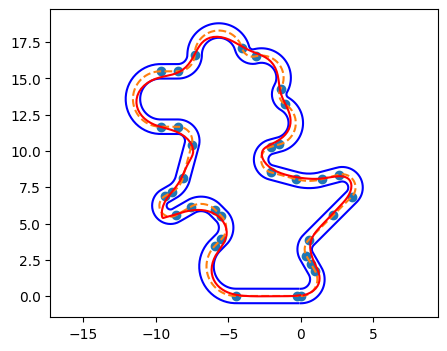

In [37]:
plotClosedLoopLMPCbyIndex(lmpc, map, -1)


/tmp/ipykernel_33230/1433507954.py:380: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(np.squeeze(index))[0])


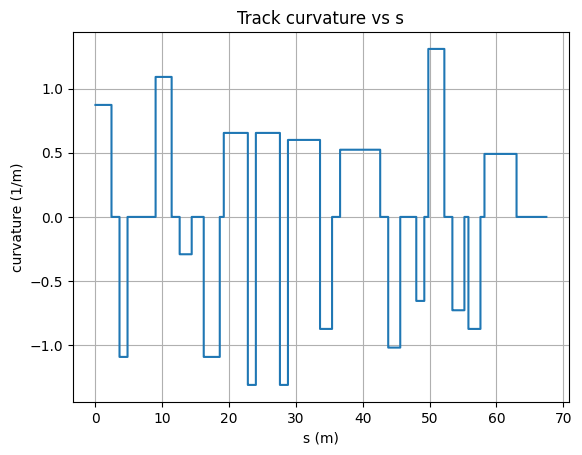

In [288]:
# Example: plot curvature along the track
m = Map()
ax = m.plotCurvature(ds=0.01)


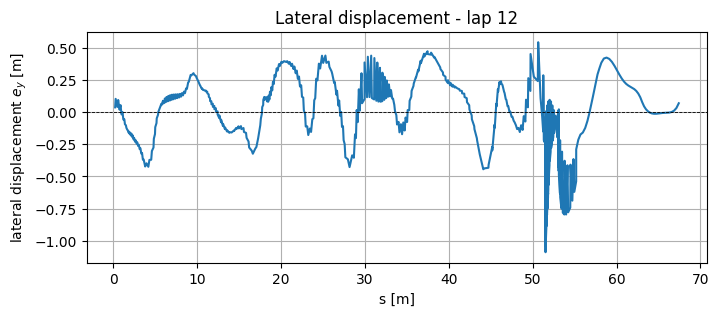

In [32]:
def plot_lateral_displacement(SS_or_lmpc, lap=-2, map_obj=None, ax=None, figsize=(8,3), show=True, color='C0'):
    """Plot lateral displacement (ey) versus curvilinear coordinate s for a given lap.

    Parameters
    ----------
    SS_or_lmpc : list, np.ndarray, or object
        Either a list of lap trajectories (each is an array with state columns),
        a single trajectory array, or an object that contains attribute `SS`
        (e.g., the LMPC object used in this notebook).
    lap : int, optional
        Lap index (0-based). If -1 (default) uses the last lap available.
    map_obj : Map, optional
        Map object to get TrackLength for wrapping s. If omitted the function
        will try to use a global `m` Map or an accessible map on the provided object.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If omitted the function will create a new figure.
    figsize : tuple, optional
        Figure size used when creating a new figure.
    show : bool, optional
        Whether to call `plt.show()`.
    color : str, optional
        Line color.

    Returns
    -------
    s, ey : np.ndarray
        Curvilinear distance and lateral displacement arrays (sorted by s).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract trajectory
    if hasattr(SS_or_lmpc, 'SS'):
        SS_list = SS_or_lmpc.SS
    elif isinstance(SS_or_lmpc, list):
        SS_list = SS_or_lmpc
    elif isinstance(SS_or_lmpc, np.ndarray):
        SS_list = None
        traj = SS_or_lmpc
    else:
        raise TypeError('SS_or_lmpc must be a list, ndarray, or an object with attribute SS')

    if SS_list is not None:
        if len(SS_list) == 0:
            raise ValueError('Provided SS list is empty')
        if lap == -1:
            lap_idx = len(SS_list) - 1
        else:
            lap_idx = int(lap)
        if not (0 <= lap_idx < len(SS_list)):
            raise IndexError('lap index out of range')
        traj = SS_list[lap_idx]
    else:
        lap_idx = lap if lap != -1 else 0

    # s and ey indices based on state definition used in this notebook
    s = traj[:, 4].copy()
    ey = traj[:, 5].copy()

    # Determine track length for wrapping (if available)
    tracklength = None
    if map_obj is not None:
        tracklength = getattr(map_obj, 'TrackLength', None)
    elif 'm' in globals() and hasattr(m, 'TrackLength'):
        tracklength = m.TrackLength
    elif hasattr(SS_or_lmpc, 'predictiveModel') and hasattr(SS_or_lmpc.predictiveModel, 'map'):
        tracklength = SS_or_lmpc.predictiveModel.map.TrackLength

    if tracklength is not None:
        s = np.mod(s, tracklength)

    # Sort by s for plotting
    idx = np.argsort(s)
    s_sorted = s[idx]
    ey_sorted = ey[idx]

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(s_sorted, ey_sorted, color=color, lw=1.5)
    ax.axhline(0, color='k', lw=0.6, ls='--')
    ax.set_xlabel('s [m]')
    ax.set_ylabel('lateral displacement $e_y$ [m]')
    ax.set_title(f'Lateral displacement - lap {lap_idx}')
    ax.grid(True)

    if show:
        plt.show()

    return s_sorted, ey_sorted


# Example usage (uncomment and adapt to your objects):
s, ey = plot_lateral_displacement(lmpc, lap=-1)  # if you have an LMPC object named `lmpc`
# s, ey = plot_lateral_displacement(lmpc.SS, lap=0)  # if you want to pass the SS list directly

# Save lap times at each LMPC iteration

The lap times are saved to csv files to for data analysis.

In [38]:
def save_lap_times_csv(lmpc, filename='lap_times.csv', dt=None, use_pandas=True):
    """Save completed laps and lap times to a CSV file.

    Parameters
    ----------
    lmpc : object
        LMPC object containing `LapTime` (number of timesteps per lap).
    filename : str
        Output CSV path (relative or absolute).
    dt : float, optional
        Timestep in seconds. If None, tries to use global `dt` (common in this notebook) and falls back to 0.1 s.
    use_pandas : bool
        Try to use pandas if available; otherwise fall back to csv module.

    Output CSV columns: lap_index, lap_steps, lap_time_s
    """

    if dt is None:
        dt = globals().get('dt', 0.1)

    lap_steps = np.array(getattr(lmpc, 'LapTime', []))
    if lap_steps.size == 0:
        raise ValueError('No lap data found in `lmpc.LapTime`')

    lap_time_s = lap_steps * dt
    data = {
        'lap_index': np.arange(len(lap_steps)),
        'lap_steps': lap_steps.astype(int),
        'lap_time_s': lap_time_s.astype(float)
    }

    # Try pandas if requested
    if use_pandas:
        try:
            df = pd.DataFrame(data)
            df.to_csv(filename, index=False)
            print(f"Saved {len(df)} laps to {filename} (pandas)")
            return df
        except Exception:
            pass

    # Fallback to csv module
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['lap_index', 'lap_steps', 'lap_time_s'])
        for i, (steps, t) in enumerate(zip(data['lap_steps'], data['lap_time_s'])):
            writer.writerow([i, int(steps), float(t)])

    print(f"Saved {len(data['lap_index'])} laps to {filename} (csv)")
    return data



In [39]:
save_lap_times_csv(lmpc, filename=filename)

Saved 13 laps to k1_10_k2_1.csv (pandas)


,lap_index,lap_steps,lap_time_s
0,0,3000,300.0
1,1,3000,300.0
2,2,3000,300.0
3,3,3000,300.0
4,4,496,49.6
5,5,369,36.9
6,6,324,32.4
7,7,316,31.6
8,8,304,30.4
9,9,294,29.4


# Plot comparison of lap times 

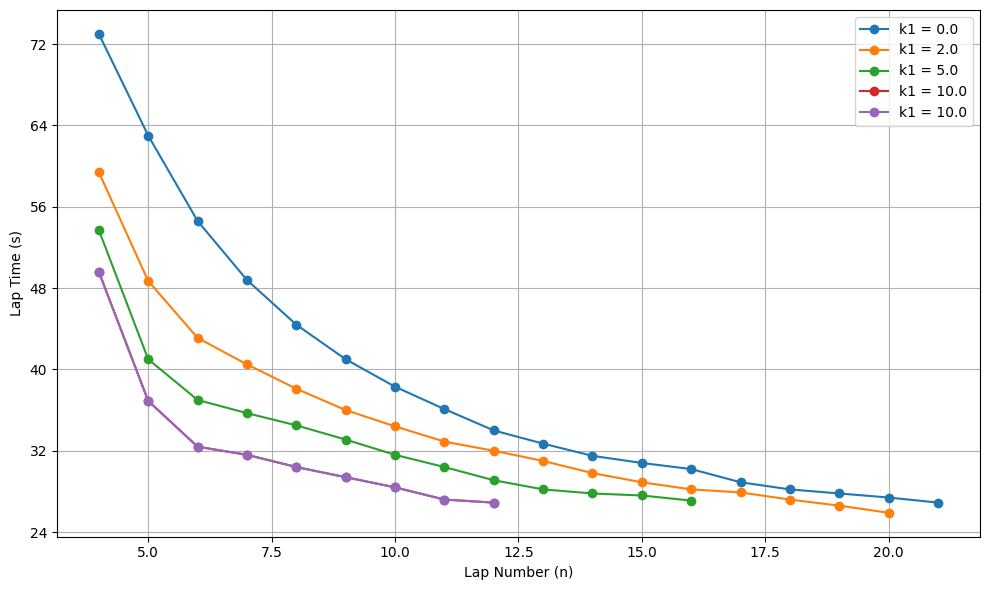

In [41]:
def plot_lap_times_sorted():
    csv_files = glob.glob("k1_*.csv")
    
    if not csv_files:
        print("No matching CSV files found.")
        return

    files_with_k2 = []
    for file in csv_files:
        base = os.path.basename(file)
        parts = base.split("_")
        if len(parts) >= 3:
            try:
                k2_val = float(parts[1])
                files_with_k2.append((k2_val, file))
            except ValueError:
                print(f"Skipping {file}, cannot parse k2 as float")
                continue
        else:
            print(f"Skipping {file}, unexpected filename format")
            continue

    files_with_k2.sort(key=lambda x: x[0])

    plt.figure(figsize=(10,6))

    for k2_val, file in files_with_k2:
        df = pd.read_csv(file)
        if 'lap_index' not in df.columns or 'lap_time_s' not in df.columns:
            print(f"Skipping {file}, missing required columns.")
            continue

        lap_numbers = df['lap_index']
        lap_times = df['lap_time_s']

        plt.plot(lap_numbers[4:], lap_times[4:], marker='o', label=f'k1 = {k2_val}')

    plt.xlabel("Lap Number (n)")
    plt.ylabel("Lap Time (s)")

    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_lap_times_sorted()

# Shape of Cost Decay Function

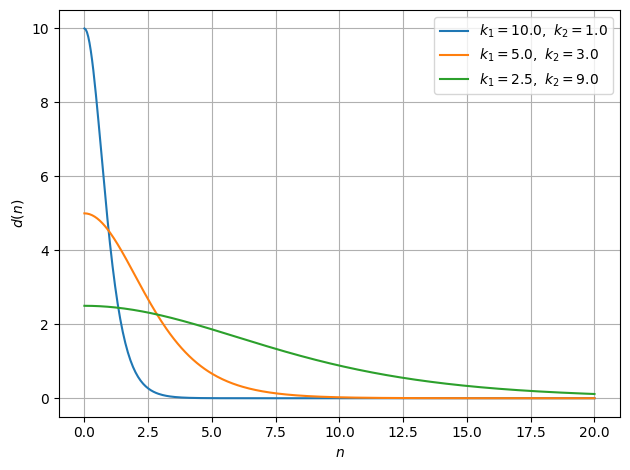

In [ ]:
n = np.linspace(0, 20, 400)

params = [
    (10.0, 1.0),
    (5.0, 3.0),
    (2.5, 9.0)
]

plt.figure()

for k1, k2 in params:
    d_n = k1 * (1 - np.tanh(n / k2)**2)
    plt.plot(n, d_n, label=rf"$k_1={k1},\ k_2={k2}$")

plt.xlabel(r"$n$")
plt.ylabel(r"$d(n)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Shape of Cost Error Function (In Curves)

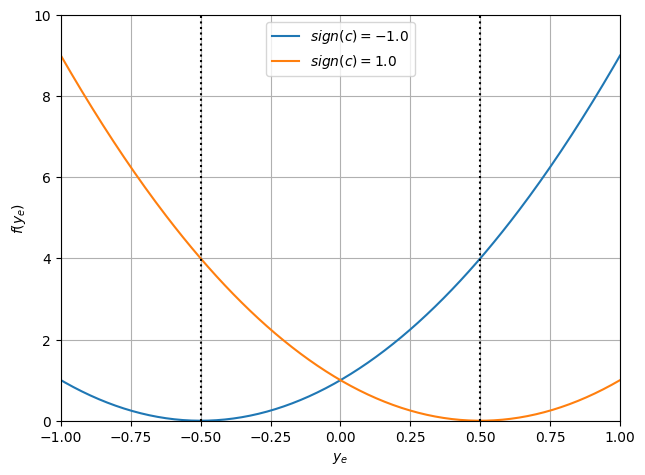

In [ ]:
ye = np.linspace(-2, 1, 400)
halfWidth = map.halfWidth

plt.figure()

for c in [-1.0, 1.0]:
    f_ye = ((ye - halfWidth * np.sign(c)) / halfWidth)**2
    plt.plot(ye, f_ye, label=rf"$sign(c)={np.sign(c)}$")

plt.axvline(+halfWidth, linestyle=":", color="black")
plt.axvline(-halfWidth, linestyle=":", color="black")

plt.xlabel(r"$y_e$")
plt.ylabel(r"$f(y_e)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-1, 1)
plt.ylim(0, 10)
plt.show()
